In [1]:
import numpy as np
from scipy.spatial import ConvexHull

import plotly.graph_objects as go
import matplotlib.pyplot as plt

# 1


In [2]:
def _simplex_1p(A, c, bs_i, eps=1e-6):
    """
    max. c^T x
    s.t. A[:][:-1] x == A[:][-1], x >= 0, A[i][bs_i[i]] != 0, x[!bs_i] == 0
    returns x[i] < 0: x[i] = inf
    """
    m, n = A.shape
    assert (m < n) and (c.shape == n,) and (len(bs_i) == m)
    x = np.zeros(n - 1)
    for i in range(m):
        assert (0 <= bs_i[i] < (n - 1)) and abs(A[i][bs_i[i]]) > eps
        A[i] /= A[i][bs_i[i]]
        c -= c[bs_i[i]] * A[i]
        for j in range(m):
            if i != j:
                A[j] -= A[j][bs_i[i]] * A[i]
    for i in range(m):
        assert A[i][-1] >= -eps
        x[bs_i[i]] = A[i][-1]
    while c[idx1 := np.argmin(c[:-1])] < -eps:
        x[idx1] = np.inf
        idx2 = -1
        for i in range(m):
            if A[i][idx1] > eps:
                tmp = A[i][-1] / A[i][idx1]
                if x[idx1] - tmp > eps:
                    idx2 = i
                    x[idx1] = tmp
            elif (idx2 < 0) and (A[i][idx1] < -eps):
                idx2 = i
        if idx2 >= 0:
            if x[idx1] == np.inf:
                x[idx1] = -1
                for i in range(m):
                    if A[i][idx1] < -eps:
                        x[bs_i[i]] = A[i][idx1]
            else:
                x[bs_i[idx2]] = 0
                bs_i[idx2] = idx1
                A[idx2] /= A[idx2][idx1]
                c -= c[idx1] * A[idx2]
                for i in range(m):
                    if i != idx2:
                        A[i] -= A[i][idx1] * A[idx2]
                        x[bs_i[i]] = A[i][-1]
        if x[idx1] < -eps:
            c[-1] = np.inf
            break
    return c[-1], x

In [3]:
def simplex(A, b, c, eps=1e-6):
    """
    max. c^T x
    s.t. A x <= b, x >= 0
    returns x[i] < 0: x[i] = inf
    """
    m, n = A.shape
    assert (c.shape == n,) and (b.shape == m,)
    A_ = np.concatenate((A, np.eye(m), b.reshape(-1, 1)), axis=1)
    c_ = np.concatenate((-c, np.zeros(m + 1)))
    bs_i = list(range(n, n + m))
    a_i = []
    for i in range(m):
        if A_[i][-1] < -eps:
            a_i.append(i)
    if a_i:
        l = len(a_i)
        A_ = np.concatenate((np.zeros((m, l)), A_), axis=1)
        for i in range(m):
            bs_i[i] += l
        for i in range(l):
            A_[a_i[i]][i] = -1
            bs_i[a_i[i]] = i
        res = _simplex_1p(
            A_, np.concatenate((np.ones(l), np.zeros(n + m + 1))), bs_i, eps
        )
        if abs(res[0]) > eps:
            return None, None
        else:
            A_ = A_[:, l:]
            for i in range(m):
                bs_i[i] -= l
    res = _simplex_1p(A_, c_, bs_i, eps)
    return res[0], res[1][:n]

In [4]:
A = np.array([[2, 1], [1, 1], [1, 0]])
b = np.array([20, 18, 8])
c = np.array([7, 4])
display(simplex(A, b, c))

(np.float64(78.0), array([ 2., 16.]))

In [5]:
A = np.array([[-3, -2], [-1, -4], [1, 1]])
b = np.array([-3, -4, 5])
c = np.array([5, 8])
display(simplex(A, b, c))

(np.float64(40.0), array([0., 5.]))

In [6]:
A = np.array([[1, 1, -3], [-4, 1, -1], [-2, -3, 1]])
b = np.array([8, -2, -4])
c = np.array([-2, 1, -1])
display(simplex(A, b, c))

(np.float64(inf), array([-0.4, -2.6, -1. ]))

In [7]:
A = np.array([[2, 1], [-1, -1]])
b = np.array([2, -5])
c = np.array([3, 1])
display(simplex(A, b, c))

(None, None)

# 2


In [8]:
points = np.array(
    [[5, 1, 15], [23, 2, 17], [32, 15, 21], [20, 21, 11], [13, 5, 29], [20, 3, 2]]
)
hull = ConvexHull(points)

In [9]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter3d(
#         x=points[:, 0],
#         y=points[:, 1],
#         z=points[:, 2],
#         mode="markers",
#         marker=dict(size=5, color="red"),
#         name="points",
#         showlegend=True,
#     )
# )
# fig.add_trace(
#     go.Mesh3d(
#         x=points[:, 0],
#         y=points[:, 1],
#         z=points[:, 2],
#         i=hull.simplices[:, 0],
#         j=hull.simplices[:, 1],
#         k=hull.simplices[:, 2],
#         color="blue",
#         opacity=0.5,
#         name="Convex Hull",
#         showlegend=True,
#     )
# )

# fig.update_layout(
#     title="Points and Convex Hull",
#     scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z"),
#     width=800,
#     height=600,
# )
# fig.show()

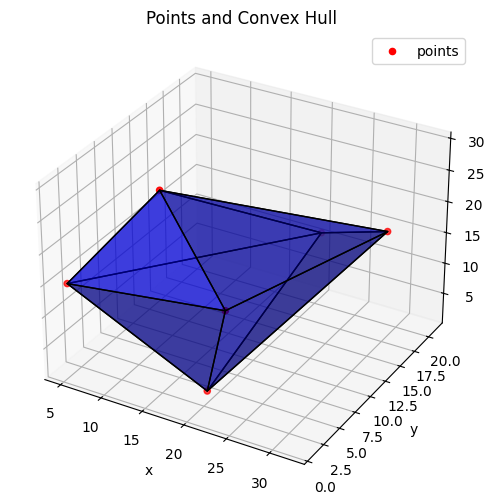

In [10]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    color="red",
    label="points",
)
ax.plot_trisurf(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    triangles=hull.simplices,
    color="blue",
    edgecolor="black",
    alpha=0.5,
)
ax.set_title("Points and Convex Hull")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

plt.show()

# 3


## 1


In [11]:
f = lambda x: np.exp(2 * x)

x_vals = np.linspace(-5, 5, 1000)

In [12]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=x_vals,
#         y=f(x_vals),
#         mode="lines",
#         name="f",
#     )
# )

# fig.update_layout(
#     title="f", xaxis_title="x", yaxis_title="f", showlegend=True, width=800, height=600
# )
# fig.show()

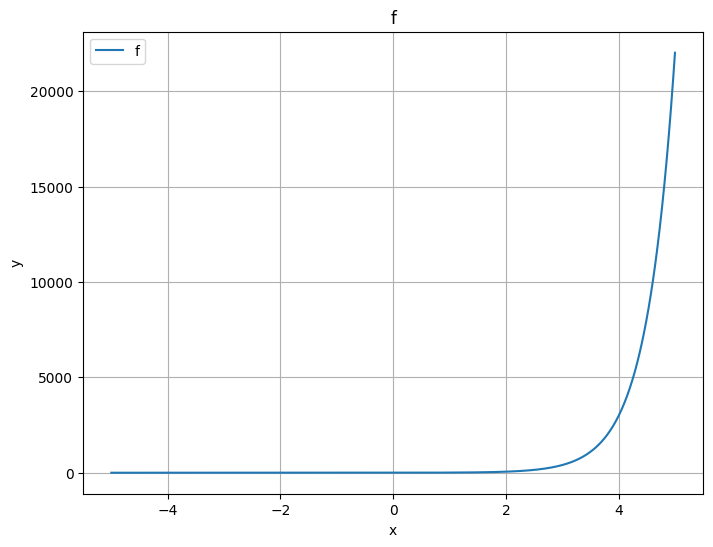

In [13]:
fig = plt.figure(figsize=(8, 6))

plt.plot(x_vals, f(x_vals), label="f", linestyle="-")

plt.title("f")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

## 2


In [14]:
f = lambda x: x**1.1

x_vals = np.linspace(0, 5, 1000)

In [15]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=x_vals,
#         y=f(x_vals),
#         mode="lines",
#         name="f",
#     )
# )

# fig.update_layout(
#     title="f", xaxis_title="x", yaxis_title="f", showlegend=True, width=800, height=600
# )
# fig.show()

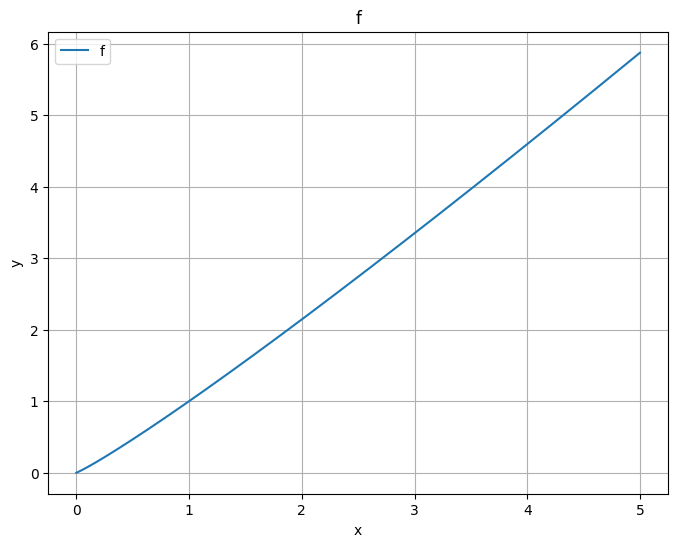

In [16]:
fig = plt.figure(figsize=(8, 6))

plt.plot(x_vals, f(x_vals), label="f", linestyle="-")

plt.title("f")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

## 3


In [17]:
f = lambda x: x**0.5

x_vals = np.linspace(0, 5, 1000)

In [18]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=x_vals,
#         y=f(x_vals),
#         mode="lines",
#         name="f",
#     )
# )

# fig.update_layout(
#     title="f", xaxis_title="x", yaxis_title="f", showlegend=True, width=800, height=600
# )
# fig.show()

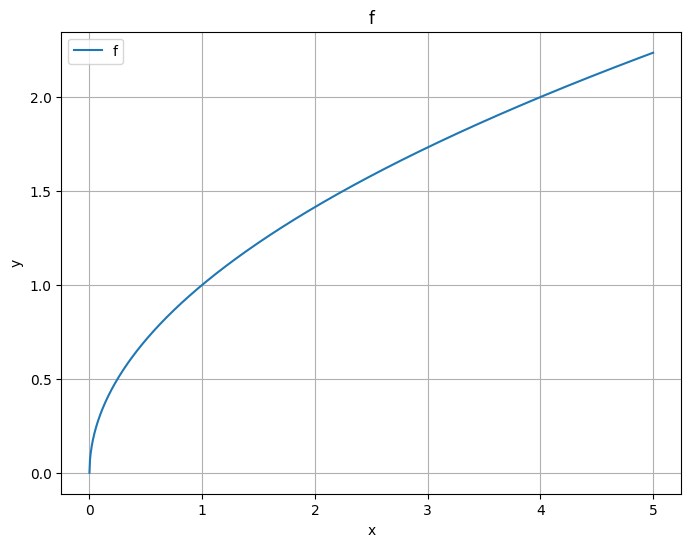

In [19]:
fig = plt.figure(figsize=(8, 6))

plt.plot(x_vals, f(x_vals), label="f", linestyle="-")

plt.title("f")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

## 4


In [20]:
f = lambda x: np.abs(x) ** 1.5

x_vals = np.linspace(-5, 5, 1000)

In [21]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=x_vals,
#         y=f(x_vals),
#         mode="lines",
#         name="f",
#     )
# )

# fig.update_layout(
#     title="f", xaxis_title="x", yaxis_title="f", showlegend=True, width=800, height=600
# )
# fig.show()

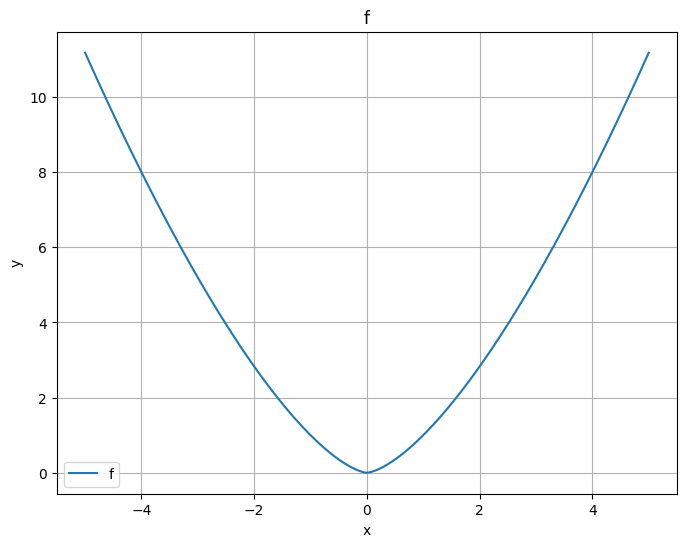

In [22]:
fig = plt.figure(figsize=(8, 6))

plt.plot(x_vals, f(x_vals), label="f", linestyle="-")

plt.title("f")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

## 5


In [23]:
f = lambda x: np.log(x)

x_vals = np.linspace(1e-6, 50, 1000)

In [24]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=x_vals,
#         y=f(x_vals),
#         mode="lines",
#         name="f",
#     )
# )

# fig.update_layout(
#     title="f", xaxis_title="x", yaxis_title="f", showlegend=True, width=800, height=600
# )
# fig.show()

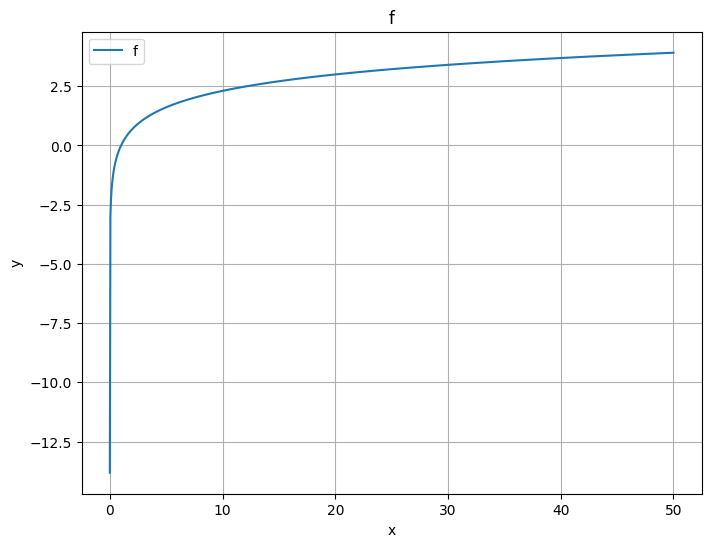

In [25]:
fig = plt.figure(figsize=(8, 6))

plt.plot(x_vals, f(x_vals), label="f", linestyle="-")

plt.title("f")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

## 6


In [26]:
f = lambda x: x * np.log2(x)

x_vals = np.linspace(1e-6, 10, 1000)

In [27]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=x_vals,
#         y=f(x_vals),
#         mode="lines",
#         name="f",
#     )
# )

# fig.update_layout(
#     title="f", xaxis_title="x", yaxis_title="f", showlegend=True, width=800, height=600
# )
# fig.show()

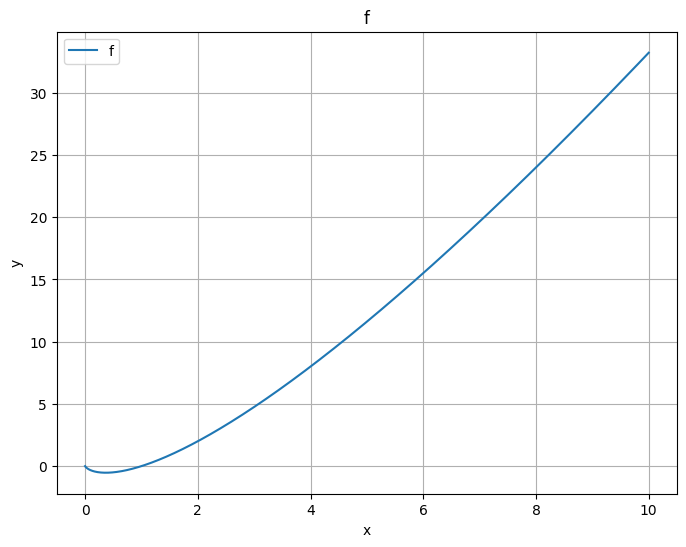

In [28]:
fig = plt.figure(figsize=(8, 6))

plt.plot(x_vals, f(x_vals), label="f", linestyle="-")

plt.title("f")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

# 4


## 1


In [29]:
f = lambda x: x**2
g = lambda x, t: f(x) / t

x_grid, t_grid = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(1e-6, 10, 100))

In [30]:
# fig = go.Figure()

# fig.add_trace(
#     go.Surface(
#         x=x_grid,
#         y=t_grid,
#         z=g(x_grid, t_grid),
#         colorscale="viridis",
#         opacity=0.85,
#         colorbar=dict(len=0.75),
#     )
# )

# fig.update_layout(
#     title="Perspective Proj.",
#     scene=dict(xaxis_title="x", yaxis_title="t", zaxis_title="g"),
#     width=800,
#     height=600,
# )
# fig.show()

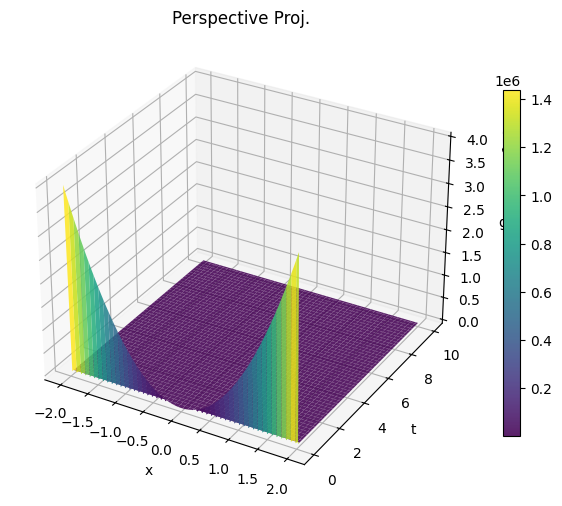

In [31]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(x_grid, t_grid, g(x_grid, t_grid), cmap="viridis", alpha=0.875)

plt.colorbar(surf, shrink=0.75)
ax.set_title("Perspective Proj.")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("g")
plt.show()

## 2


In [32]:
f = lambda x: -np.log(x)
g = lambda x, t: f(x) / t

x_grid, t_grid = np.meshgrid(np.linspace(1e-6, 2, 100), np.linspace(1e-6, 10, 100))

In [33]:
# fig = go.Figure()

# fig.add_trace(
#     go.Surface(
#         x=x_grid,
#         y=t_grid,
#         z=g(x_grid, t_grid),
#         colorscale="viridis",
#         opacity=0.85,
#         colorbar=dict(len=0.75),
#     )
# )

# fig.update_layout(
#     title="Perspective Proj.",
#     scene=dict(xaxis_title="x", yaxis_title="t", zaxis_title="g"),
#     width=800,
#     height=600,
# )
# fig.show()

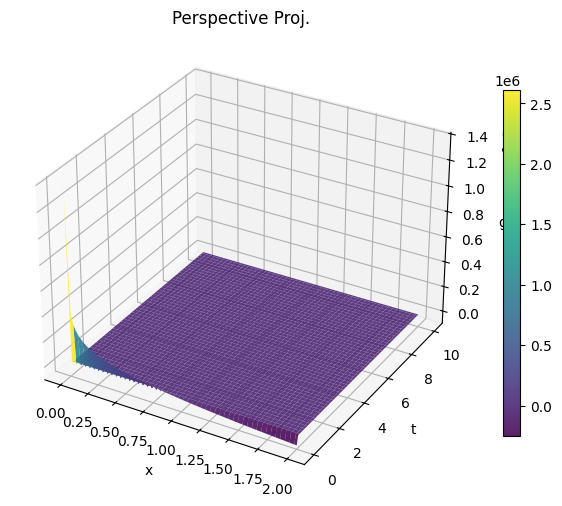

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(x_grid, t_grid, g(x_grid, t_grid), cmap="viridis", alpha=0.875)

plt.colorbar(surf, shrink=0.75)
ax.set_title("Perspective Proj.")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("g")
plt.show()